## Introduction to CML data processing - From raw signals to rain rates

<img src="https://wires.onlinelibrary.wiley.com/cms/asset/e241f352-21c4-49e7-a8f7-ecf6ff15686f/wat21337-fig-0001-m.jpg" alt="drawing" width="1300"/>

<img src="https://hess.copernicus.org/articles/24/2931/2020/hess-24-2931-2020-f03-web.png" alt="drawing" width="1000"/>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.append('poligrain/src')
sys.path.append('pycomlink')

import poligrain as plg
import pycomlink as pycml

## Load OpenMRG example dataset

We have already learned about this in the previous notebook.

In [2]:
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

ds_cmls = ds_cmls.rename_vars({'R': 'R_example'})

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


In [3]:
ds_cmls

<xarray.Dataset> Size: 1GB
Dimensions:       (sublink_id: 2, cml_id: 364, time: 69120)
Coordinates:
  * sublink_id    (sublink_id) <U9 72B 'sublink_1' 'sublink_2'
  * cml_id        (cml_id) int64 3kB 10001 10002 10003 ... 10362 10363 10364
  * time          (time) datetime64[ns] 553kB 2015-07-22 ... 2015-07-29T23:59:50
    site_0_lat    (cml_id) float64 3kB ...
    site_0_lon    (cml_id) float64 3kB ...
    site_1_lat    (cml_id) float64 3kB ...
    site_1_lon    (cml_id) float64 3kB ...
    frequency     (sublink_id, cml_id) float64 6kB ...
    polarization  (sublink_id, cml_id) <U1 3kB ...
    length        (cml_id) float64 3kB ...
Data variables:
    tsl           (time, sublink_id, cml_id) float64 403MB ...
    rsl           (time, sublink_id, cml_id) float64 403MB ...
    R_example     (sublink_id, cml_id, time) float64 403MB ...
Attributes: (12/14)
    title:                 OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

Note, that this is data for 364 CMLs, each with two sublinks, with a temporal reslotion of 10 sec. For a 8-day period, this is approx. 1.2 GB of data if loaded into memory. CML data can be quite large!

In [4]:
print(f'{ds_cmls.nbytes/1e6:.2f} MB')

1208.24 MB


## Explore CML data

### The transmitted and received signal levels

ADD SOME TEXT HERE

- RSL most important for rainfall estimation
- TSL can be constant or vary with time if ATPC (automatic transmit power control) is enabled
- RSL and TSL are quantized, often at 0.3 dB for RSL and 1.0 dB for TSL

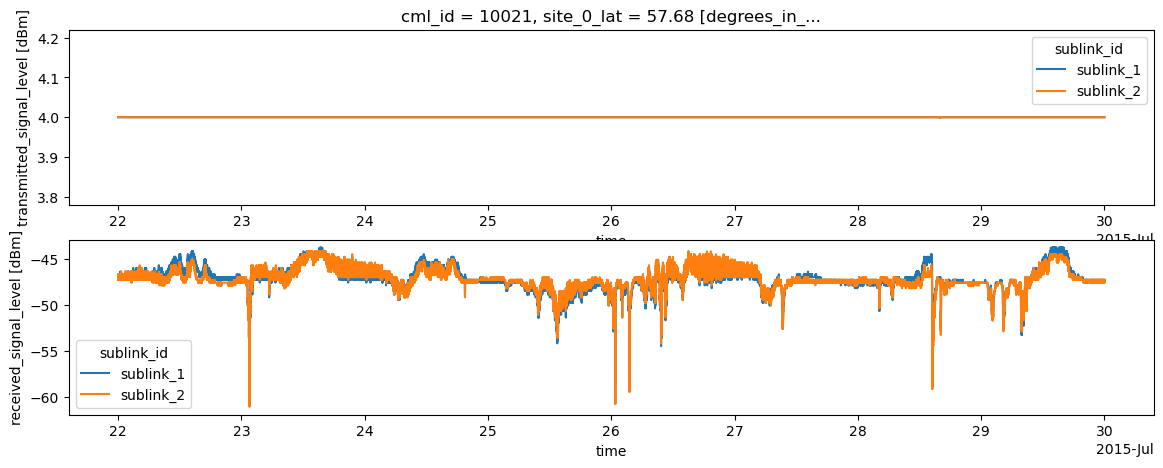

In [5]:
ds_cml = ds_cmls.isel(cml_id=20) 

fig, axs = plt.subplots(2, 1, figsize=(14, 5))
ds_cml.tsl.plot.line(x='time', ax=axs[0])
ds_cml.rsl.plot.line(x='time', ax=axs[1])
axs[1].set_title('');

 * rsl value of -99 is an outlier (some error happend at this time-step)
 
&#8594; replace such default values by NaN (Not a Number)

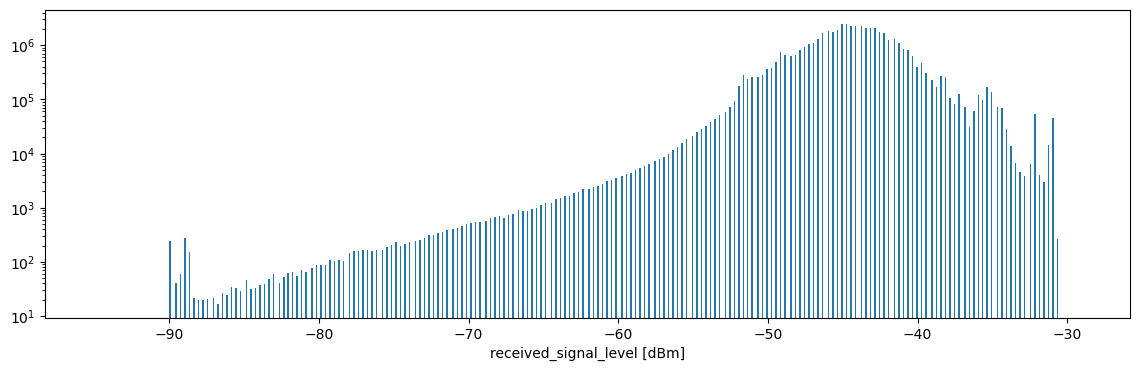

In [6]:
ds_cmls.rsl.plot.hist(bins=np.arange(-95, -29, 0.1), figsize=(14, 4))
plt.yscale('log')

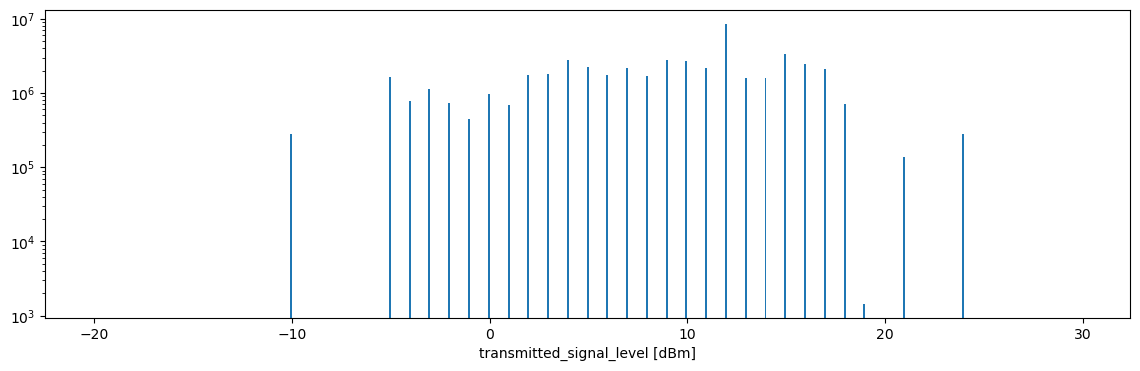

In [7]:
ds_cmls.tsl.plot.hist(bins=np.arange(-20, 30, 0.1), figsize=(14, 4))
plt.yscale('log')

## Exercise 1: Find CML with enabled ATPC

- 1.1: How many CMLs have the ATPC enabled? Plo a histogram of the range of the TSL values of each CML.


- 1.2: Find a CML with enabled ATPC and plot TSL and RSL. Can you explain what is happening during rain events?

- 1.3: Find the CML with the largest range of TSL values and plot TSL and RSL. (Hint: use `.argmax` to get the index of the maximum in a `xarray.DataArray`)

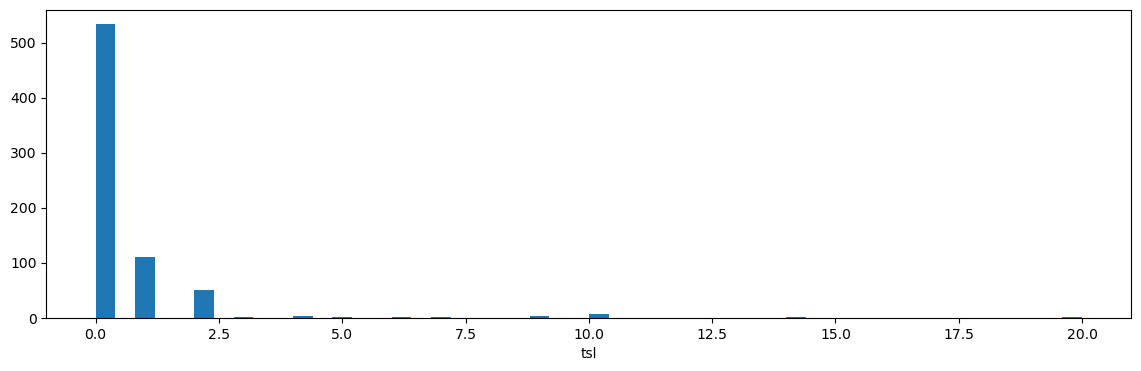

In [8]:
tsl_range = ds_cmls.tsl.max(dim='time') - ds_cmls.tsl.min(dim='time')
tsl_range.plot.hist(bins=50, figsize=(14, 4));

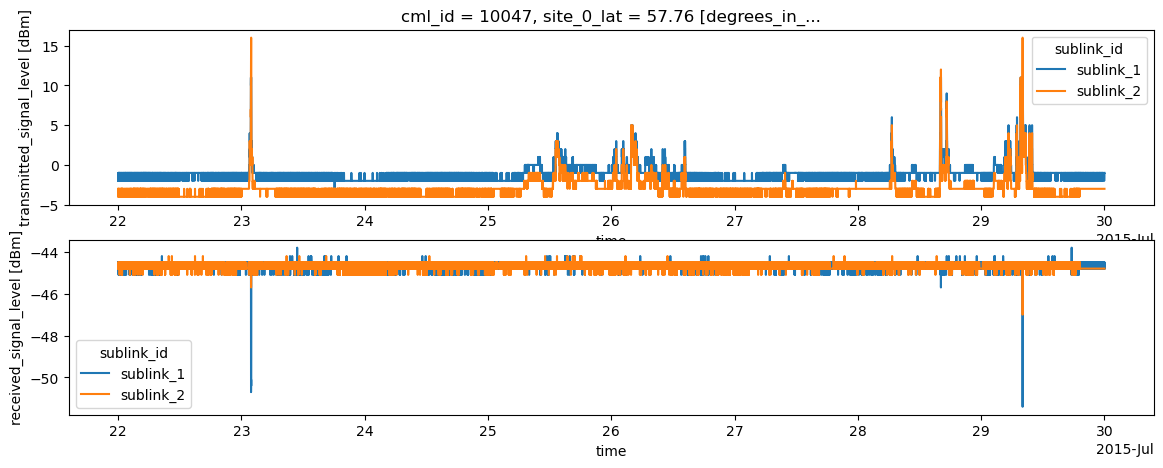

In [9]:
i_max = tsl_range.argmax(dim='cml_id').data[0]
ds_cml = ds_cmls.isel(cml_id=i_max)
fig, axs = plt.subplots(2, 1, figsize=(14, 5))
ds_cml.tsl.plot.line(x='time', ax=axs[0])
ds_cml.rsl.plot.line(x='time', ax=axs[1])
axs[1].set_title('');

## The total path loss (TL) calculated from TSL and RSL

TL = TSL - RSL

TL is the data that we typically work with. It increases during rain events because the rain causes additional attenuation along the path which add to the total path loss during clear sky conditions.

In [10]:
ds_cmls['tl'] = ds_cmls.tsl - ds_cmls.rsl

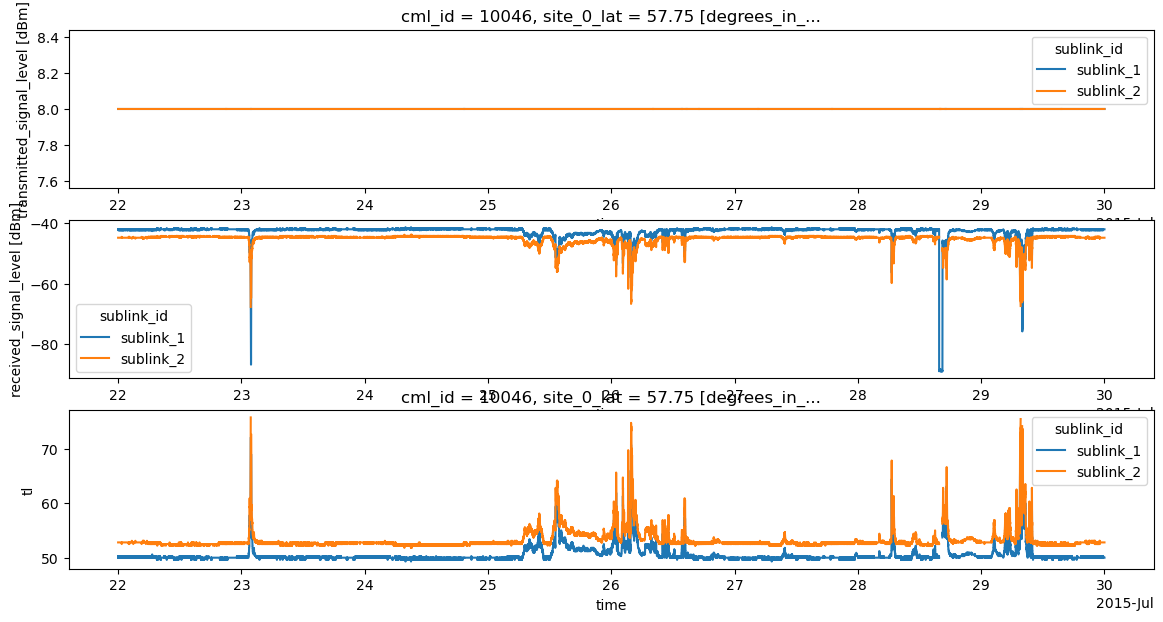

In [11]:
ds_cml = ds_cmls.isel(cml_id=45)
fig, axs = plt.subplots(3, 1, figsize=(14, 7))
ds_cml.tsl.plot.line(x='time', ax=axs[0])
ds_cml.rsl.plot.line(x='time', ax=axs[1])
ds_cml.tl.plot.line(x='time', ax=axs[2])
axs[1].set_title('');

## Interpolate short gaps in TL

Due to short outages of the data acquisition of the CML data there can be short gaps in TSL and RSL, consequently also in TL. We can interpolate these gaps. The question is, however, up to which length the gaps should be interpolated?

We have found that interpolating gaps in TL up to 5 minutes is still okay.

In [12]:
ds_cmls['tl'] = ds_cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

## Processing step 1: Wet-dry classification

The goal here is to detect rain-indcued attenuation events so that we can separate them from the fluctuations of TL during dry periods.

- Rainfall generates high TL values for short periods
    
- How can we detect such periods? 

As a first, simple approach, we will use the rolling standard deviation (RSD) of TL and a threshold as suggested by [Schleiß et al. 2010](https://ieeexplore.ieee.org/document/5438724). There are different methods implemented in `pycomlink`. At the end of the notebook we will explore the "nearby-link approach" which works by comparing TL from neighboring CMLs.



<img src="https://hess.copernicus.org/articles/24/2931/2020/hess-24-2931-2020-f03-web.png" alt="drawing" width="1000"/>

### Compute a rolling standard deviation of TL

In [13]:
# here we first select one CML, later we do this for all CMLs
ds_cml = ds_cmls.isel(cml_id=7)

# RSD with a 60-minute window length (note that this is 10sec data)
ds_cml['rsd'] = ds_cml.tl.rolling(time=60*6, center=True).std() 

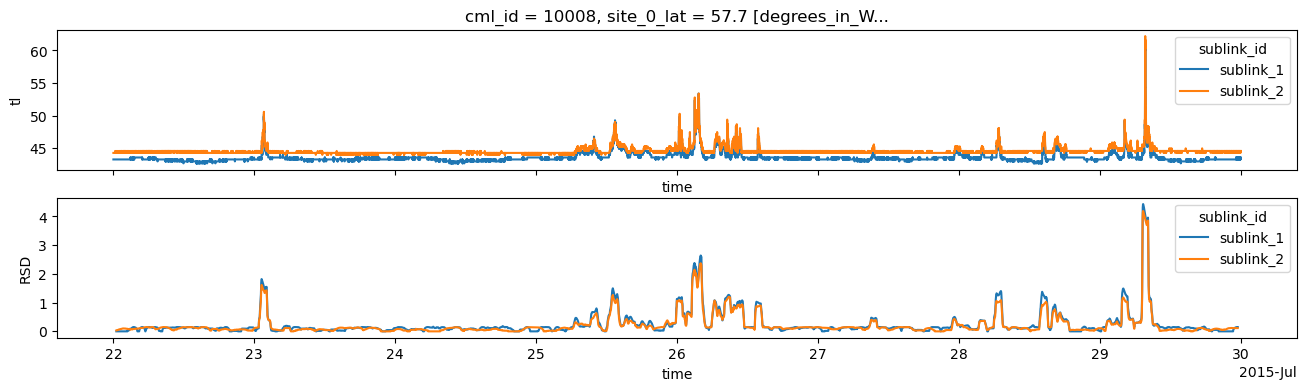

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(16,4), sharex=True)
ds_cml.tl.plot.line(x='time', ax=axs[0])
ds_cml.rsd.plot.line(x='time', ax=axs[1])
axs[0].set_ylabel('tl')
axs[1].set_ylabel('RSD')
axs[1].set_title('');

### 

**Question**: What is a suitable threshold?


|

|

### Apply a threshold to divide TL into wet (rainy) and dry (non-rainy) periods

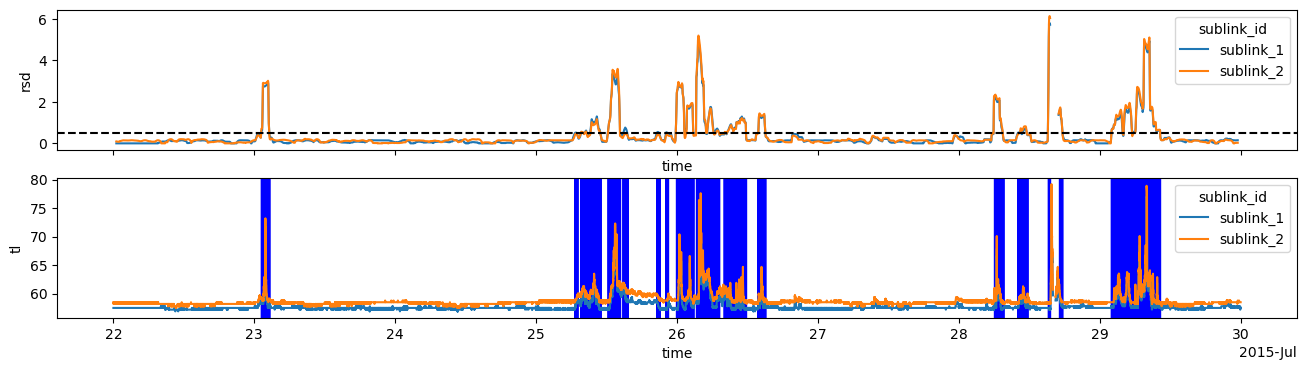

In [15]:
threshold = 0.5
ds_cml = ds_cmls.isel(cml_id=123)

ds_cml['rsd'] = ds_cml.tl.rolling(time=60*6, center=True).std() 
ds_cml['wet'] = ds_cml.rsd > threshold

# Plot RSL of TL and threshold
fig, axs = plt.subplots(2, 1, figsize=(16,4), sharex=True)
ds_cml.rsd.plot.line(x='time', ax=axs[0])
axs[0].axhline(threshold, color='k', linestyle='--', label='threshold')


# Function to mark wet periods in an existing plot
def highlight_wet_periods(da_wet, ax):
    # set first and last time stamp to NaN
    da_wet = da_wet.copy()
    da_wet = da_wet.where(da_wet.time != da_wet.time.isel(time=0), False)
    da_wet = da_wet.where(da_wet.time != da_wet.time.isel(time=-1), False)
    
    # Get start and end of dry event
    wet_start = np.roll(da_wet, -1) & ~da_wet
    wet_end = np.roll(da_wet, 1) & ~da_wet
    
    # Plot shaded area for each wet event
    for wet_start_i, wet_end_i in zip(
        wet_start.values.nonzero()[0],
        wet_end.values.nonzero()[0],
    ):
        ax.axvspan(da_wet.time.values[wet_start_i], da_wet.time.values[wet_end_i], color='b', alpha=1)

# Plot TL and mark wet periods
ds_cml.tl.plot.line(x='time', ax=axs[1]);
highlight_wet_periods(ds_cml.wet, ax=axs[1])
axs[0].set_title('');
axs[1].set_title('');

## Exercise 2: Find optimal RSD threshold for different CMLs

- 2.1: Experiment with different thresholds for different CMLs. What do you observe? What would be a good threshold that works for all CMLs?

- 2.2: Use the method from [Graf et al. 2020](https://hess.copernicus.org/articles/24/2931/2020/hess-24-2931-2020.html) to set the RSD treshold based on a "noisiness indicator", which here is the 80th quantile of the RSD (note that higher quantiles e.g. 95th are typically those of RSD during rain events)

    Code for this approach
    ```python
    ds_cml['rsd'] = ds_cml.tl.rolling(time=60*6, center=True).std() 
    ds_cml['rsd_threshold'] = ds_cml.tl.rolling(time=6*60, center=True).quantile(.80)
    ds_cml['wet'] = ds_cml.rsd > ds_cml.rsd_threshold
    ```

- 2.3 (optional): Count the number of wet data points in relation to the applied RSD threshold and plot that.

### Exercise 2.1

In [16]:
# Write code here...



In [17]:
# Caution: Running thie cell will load the solution
# if input("Enter 'Hint' to display the hints: ")=='Hint':
#     %load hints_solutions/2_1_hint.py

### Exercise 2.2

In [18]:
# Write code here...



In [19]:
# Caution: Running thie cell will load the solution
# if input("Enter 'Solution' to display solutions: ")=='Solution':
#     %load hints_solutions/2_2_solution.py

### Exercise 2.3

In [20]:
# Write code here...



In [21]:
# Caution: Running thie cell will load the solution
# if input("Enter 'Hint' to display the hints: ")=='Hint':
#     %load hints_solutions/2_3_hint.py

## Procesing step 2: Estimate the TL baseline 

In [22]:
ds_cml = ds_cmls.isel(cml_id=17)
threshold = 0.7

ds_cml['rsd'] = ds_cml.tl.rolling(time=60*6, center=True).std() 
ds_cml['wet'] = ds_cml.rsd > threshold

ds_cml['baseline'] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cml.tl, 
    wet=ds_cml.wet, 
    n_average_last_dry=5*6)  # use average of TL of last 5 minutes

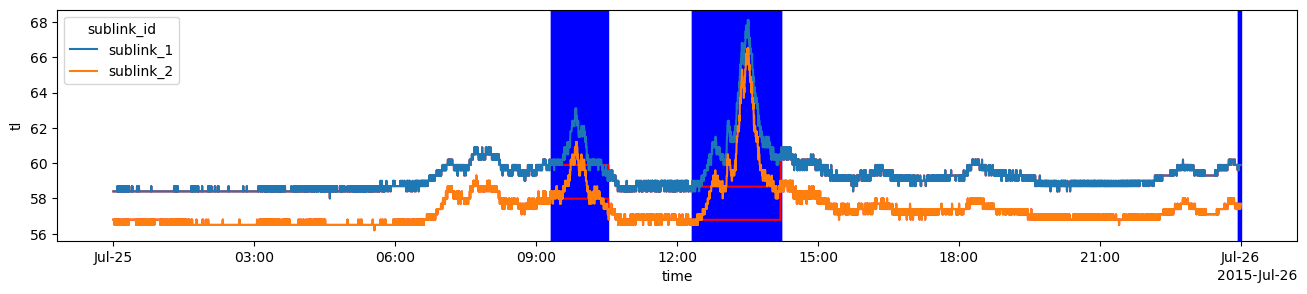

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(16,3))

ds_cml_zoom = ds_cml.sel(time='2015-07-25')
ds_cml_zoom.baseline.plot.line(x='time', ax=ax, color='r');
ds_cml_zoom.tl.plot.line(x='time', ax=ax)
ax.set_ylabel('tl');

highlight_wet_periods(ds_cml_zoom.wet, ax=ax)
ax.set_title('');

## Processing step 3: Estimate wet anteanna attenuation (WAA)

Rain drops on the antenna cover can create additional attenuation that we need to subtract before estimating the path averaged rainfall rate.

TODO add photo here

In [24]:
# do processing of one CML here again to make sure 
# that we all have the same data for the next cells
ds_cml = ds_cmls.isel(cml_id=123)
threshold = 0.7

ds_cml['rsd'] = ds_cml.tl.rolling(time=60*6, center=True).std() 
ds_cml['wet'] = ds_cml.rsd > threshold

ds_cml['baseline'] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cml.tl, 
    wet=ds_cml.wet, 
    n_average_last_dry=5*6)  # use average of TL of last 5 minutes

In [25]:
# Estimate WAA
ds_cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=ds_cml.tl, 
    baseline=ds_cml.baseline, 
    wet=ds_cml.wet, 
    waa_max=2.0, 
    delta_t=1, 
    tau=15*6, # 15 minutes
)

# subtract baseline and wet antenna attenuation from total path loss
ds_cml['A'] = ds_cml.tl - ds_cml.baseline - ds_cml.waa
# set negative values to zero
ds_cml['A'] = ds_cml.A.where(ds_cml.A > 0, 0) 

# also calc A without WAA compensation for illustration purposes
ds_cml['A_no_waa_correct'] = ds_cml.tl - ds_cml.baseline
ds_cml['A_no_waa_correct'] = ds_cml.A_no_waa_correct.where(ds_cml.A_no_waa_correct > 0, 0)

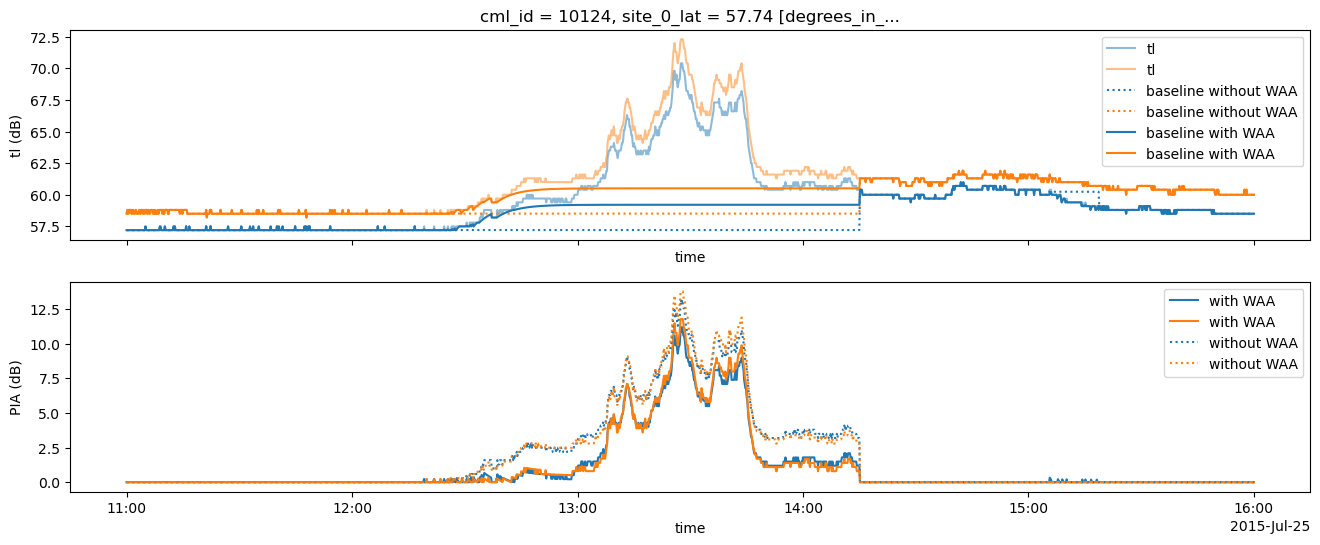

In [26]:
ds_cml_zoom = ds_cml.sel(time=slice('2015-07-25 11:00:00', '2015-07-25 16:00:00'))


fig, axs = plt.subplots(2, 1, figsize=(16,6), sharex=True)
ds_cml_zoom.tl.plot.line(x='time', alpha=0.5, label='tl', ax=axs[0])

axs[0].set_prop_cycle(None)
ds_cml_zoom.baseline.plot.line(
    x='time', 
    linestyle=':', 
    label='baseline without WAA', 
    ax=axs[0]
)

axs[0].set_prop_cycle(None)
(ds_cml_zoom.baseline + ds_cml_zoom.waa).plot.line(
    x='time', 
    label='baseline with WAA', 
    ax=axs[0]
)

ds_cml_zoom.A.plot.line(x='time', label='with WAA', ax=axs[1])
axs[1].set_prop_cycle(None)
ds_cml_zoom.A_no_waa_correct.plot.line(x='time', linestyle=':', label='without WAA', ax=axs[1])

axs[0].set_ylabel('tl (dB)')
axs[1].set_ylabel('PIA (dB)')
axs[1].set_title('')
axs[1].legend()
axs[0].legend();

## Exercise 3: Try different WAA estimation methods and parameters

- 3.1: Change the parameteres of the WAA-Schleiss method

- 3.2: Try the method from Pastorek et al. (2022) available via `pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs()`

### Exercise 3.1

In [27]:
# Write code here...



In [28]:
# Caution: Running thie cell will load the solution
# if input("Enter 'Solution' to display the solution: ")=='Solution':
#     %load hints_solutions/3_1_solution.py

### Exercise 3.2

In [29]:
# Write code here...



In [30]:
# Caution: Running thie cell will load the solution
# if input("Enter 'Solution' to display the solution: ")=='Solution':
#     %load hints_solutions/3_2_solution.py

## Processing step 4: Calculate rain rate

At the typical CML freqnencies, in particular in the range 20 GHz to 35 GHz, there is a very robust relation between specific path attenuation $k$ (in dB/km) and path-averaged rain rate $R$ (in mm/h) provided as

$$
k = a \, R^b.
$$

The following plot shows this k-R relation, calculated from several years of 1-minute drop size distribution from a laser disdrometer in southern Germany.

<img src="https://wires.onlinelibrary.wiley.com/cms/asset/0bbeb412-fe72-4d18-b201-f6dadefe60bc/wat21337-fig-0003-m.jpg" alt="drawing" width="1000"/>

Show the parameterse $a$ and $b$ from the ITU recommendation on rain-induced attenuation at microwave frequencies

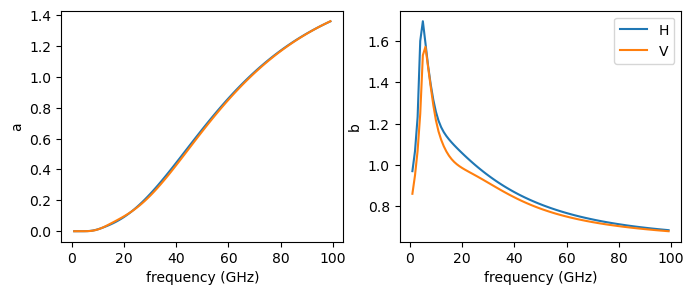

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
f_GHz_list = range(1, 100)
for pol in ['H', 'V']:
    a, b = pycml.processing.k_R_relation.a_b(f_GHz=f_GHz_list, pol=pol)
    axs[0].plot(f_GHz_list, a, label=pol)
    axs[1].plot(f_GHz_list, b, label=pol)
plt.legend()
axs[0].set_xlabel('frequency (GHz)')
axs[0].set_ylabel('a')
axs[1].set_xlabel('frequency (GHz)')
axs[1].set_ylabel('b');


In [32]:
# do processing of one CML here again to make sure 
# that we all have the same data for the next cells
ds_cml = ds_cmls.isel(cml_id=123)
threshold = 0.7

ds_cml['rsd'] = ds_cml.tl.rolling(time=60*6, center=True).std() 
ds_cml['wet'] = ds_cml.rsd > threshold

ds_cml['baseline'] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cml.tl, 
    wet=ds_cml.wet, 
    n_average_last_dry=5*6)  # use average of TL of last 5 minutes

ds_cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=ds_cml.tl, 
    baseline=ds_cml.baseline, 
    wet=ds_cml.wet, 
    waa_max=2.0, 
    delta_t=1, 
    tau=15*6, # 15 minutes
)

# subtract baseline and wet antenna attenuation from total path loss
ds_cml['A'] = ds_cml.tl - ds_cml.baseline - ds_cml.waa
# set negative values to zero
ds_cml['A'] = ds_cml.A.where(ds_cml.A > 0, 0) 

In [33]:
ds_cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cml.A, 
    L_km=float(ds_cml.length)/1000, 
    f_GHz=ds_cml.frequency/1000,
    pol=ds_cml.polarization
)

(np.float64(16641.0), np.float64(16642.0))

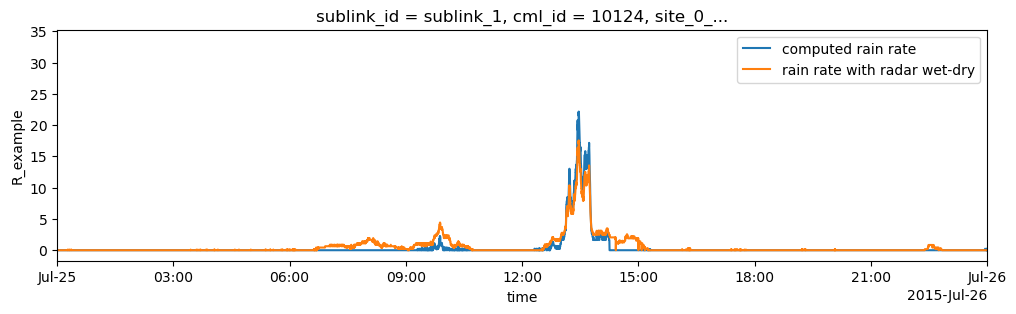

In [34]:
fig, ax = plt.subplots(figsize=(12,3))
ds_cml.isel(sublink_id=0).R.plot.line(x='time',label='computed rain rate')
ds_cml.isel(sublink_id=0).R_example.plot.line(x='time',label='rain rate with radar wet-dry')
plt.legend()

plt.xlim(pd.to_datetime('2015-07-25'), pd.to_datetime('2015-07-26'))


## Get radar rain rate along each CML for comparison

In [35]:
get_grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_rad,
    ds_line_data=ds_cmls,
)
radar_along_cml = get_grid_at_lines(da_gridded_data=ds_rad.R)

Now we can compare the processed CML rain rates with the radar

(np.float64(16641.0), np.float64(16642.0))

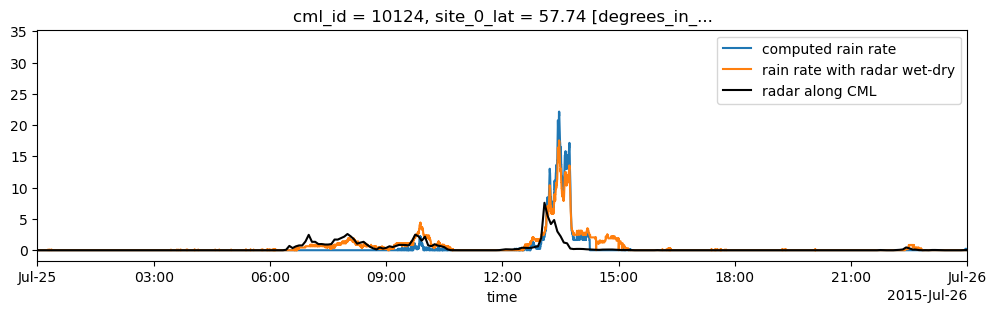

In [36]:
fig, ax = plt.subplots(figsize=(12,3))
ds_cml.isel(sublink_id=0).R.plot.line(x='time',label='computed rain rate')
ds_cml.isel(sublink_id=0).R_example.plot.line(x='time',label='rain rate with radar wet-dry')

radar_along_cml.sel(cml_id=ds_cml.cml_id.data).plot.line(x='time', color='k', label='radar along CML')

plt.legend()

plt.xlim(pd.to_datetime('2015-07-25'), pd.to_datetime('2015-07-26'))


## Exercise 4: Do full processing and compare to radar

- 4.1: Do the full processing from TL to rain rate with the code from above. Plot also the intermediate data and compare to radar. A plotting fuction for this is provided below.

- 4.2: Use `plg.validation.plot_hexbin`, `plg.validation.calculate_rainfall_metrics` and `plg.validation.plot_confusion_matrix_count` to analyse the CML rain rates compared to radar (using it as reference) for 1h rainfall sums.


### Exercise 4.1

In [37]:
# Write code here...

ds_cml = ds_cmls.isel(cml_id=123)
threshold = 0.3

# Full processing
ds_cml['rsd'] = ds_cml.tl.rolling(time=60*6, center=True).std() 
ds_cml['wet'] = ds_cml.rsd > threshold

ds_cml['baseline'] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cml.tl, 
    wet=ds_cml.wet, 
    n_average_last_dry=5*6)  # use average of TL of last 5 minutes

ds_cml['A_obs'] = ds_cml.tl - ds_cml.baseline
ds_cml["A_obs"] = ds_cml.A_obs.where(ds_cml.A_obs >= 0, 0)
# ds_cml['waa'] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
#     A_obs=ds_cml.A_obs,
#     f_Hz=ds_cml.frequency * 1e6,
#     pol=ds_cml.polarization.data,
#     L_km=ds_cml.length / 1000,
#     A_max=3,
#     zeta=0.7,  
#     d=0.15, 
# )
ds_cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=ds_cml.tl, 
    baseline=ds_cml.baseline, 
    wet=ds_cml.wet, 
    waa_max=2.0, 
    delta_t=1, 
    tau=15*6, # 15 minutes
)

# subtract baseline and wet antenna attenuation from total path loss
ds_cml['A'] = ds_cml.tl - ds_cml.baseline - ds_cml.waa
# set negative values to zero
ds_cml['A'] = ds_cml.A.where(ds_cml.A > 0, 0) 

ds_cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cml.A, 
    L_km=float(ds_cml.length)/1000, 
    f_GHz=ds_cml.frequency/1000,
    pol=ds_cml.polarization
)


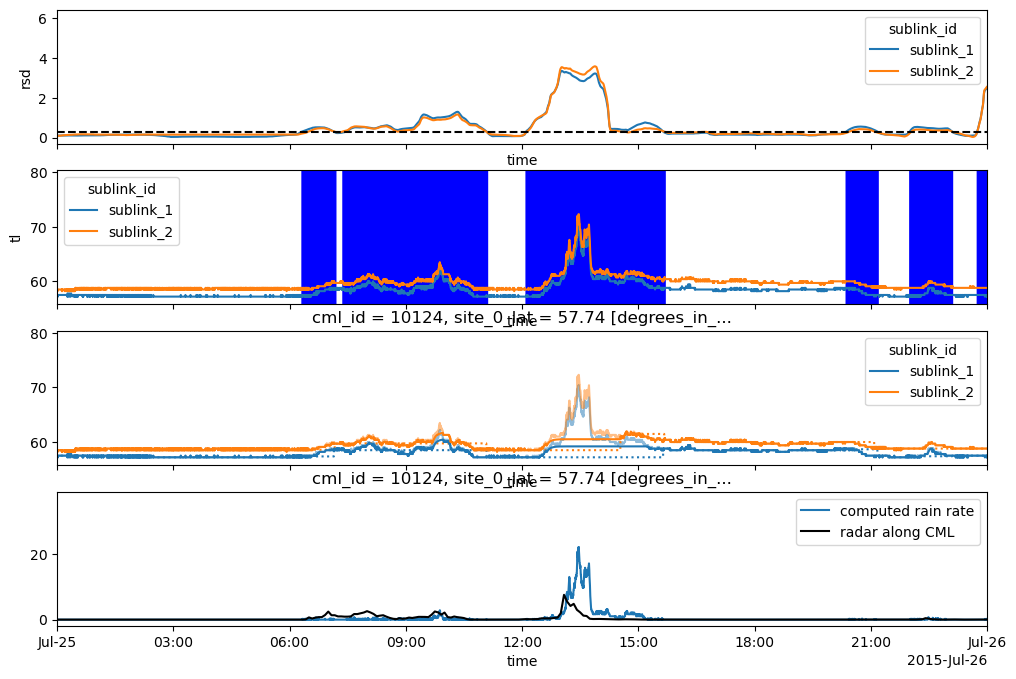

In [38]:
# Plotting function

fig, axs = plt.subplots(4, 1, figsize=(12,8), sharex=True)

# Plot RSL of TL and threshold
ds_cml.rsd.plot.line(x='time', ax=axs[0])
axs[0].axhline(threshold, color='k', linestyle='--', label='threshold')

# Plot TL and mark wet periods
ds_cml.tl.plot.line(x='time', ax=axs[1]);
highlight_wet_periods(ds_cml.wet, ax=axs[1])

# Plot TL, baseline and WAA
ds_cml.tl.plot.line(x='time', alpha=0.5, label='tl', ax=axs[2])

axs[2].set_prop_cycle(None)
ds_cml.baseline.plot.line(
    x='time', 
    linestyle=':', 
    label='baseline without WAA', 
    ax=axs[2]
)

axs[2].set_prop_cycle(None)
(ds_cml.baseline + ds_cml.waa).plot.line(
    x='time', 
    label='baseline with WAA', 
    ax=axs[2]
)

# Plot CML and radar rain rate
ds_cml.isel(sublink_id=0).R.plot.line(x='time',label='computed rain rate', ax=axs[3])
radar_along_cml.sel(cml_id=ds_cml.cml_id.data).plot.line(x='time', color='k', label='radar along CML', ax=axs[3])
plt.legend()

plt.xlim(pd.to_datetime('2015-07-25'), pd.to_datetime('2015-07-26'))

axs[0].set_title('');
axs[1].set_title('');

### Exercise 4.2

{'ref_thresh': 0.1,
 'est_thresh': 0.1,
 'pearson_correlation_coefficient': np.float64(0.54358442416981),
 'coefficient_of_variation': np.float64(1.5859414556413969),
 'root_mean_square_error': np.float64(2.473028935118075),
 'mean_absolute_error': np.float64(1.3450948087547683),
 'percent_bias': np.float64(-14.524379237581964),
 'reference_mean_rainfall': np.float64(1.5528459298854262),
 'estimate_mean_rainfall': np.float64(1.327304698053511),
 'false_positive_mean_rainfall': np.float64(0.6647017728893702),
 'false_negative_mean_rainfall': np.float64(1.0161241430396106),
 'N_all': 768,
 'N_nan': np.int64(1),
 'N_nan_ref': np.int64(1),
 'N_nan_est': np.int64(0)}

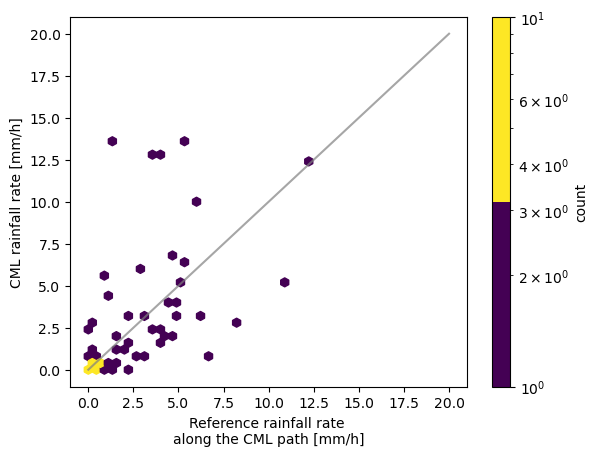

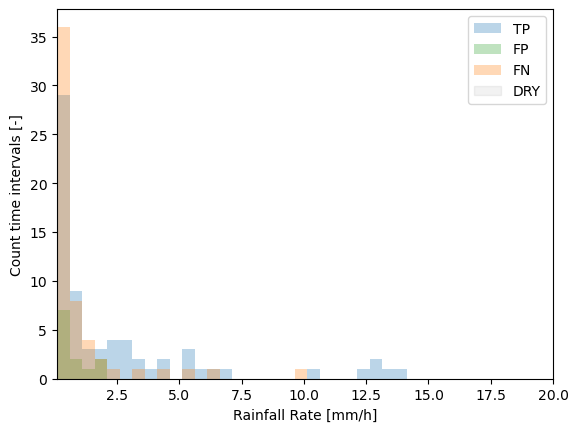

In [39]:
# Write code here...

R_cml_15min = ds_cml.isel(sublink_id=0).R.resample(time='15min').mean()
radar_along_cml_R_15min = radar_along_cml.sel(cml_id=ds_cml.cml_id.data).resample(time='15min').mean()


R_threshold = 0.1

plg.validation.plot_hexbin(
    radar_along_cml_R_15min.data.flatten(),
    R_cml_15min.data.flatten(),
    ref_thresh=R_threshold,
    est_thresh=R_threshold,
)

plg.validation.plot_confusion_matrix_count(
    reference=radar_along_cml_R_15min.data.flatten(),
    estimate=R_cml_15min.data.flatten(),
    ref_thresh=0.1,
    est_thresh=0.1,
    n_bins=200,
    bin_type='linear',
);
plt.gca().set_xscale("linear")
#plt.gca().set_yscale("log")
plt.xlim([0.09, 20])

rainfall_metrics = plg.validation.calculate_rainfall_metrics(
    reference=radar_along_cml_R_15min.data.flatten(),
    estimate=R_cml_15min.data.flatten(),
    ref_thresh=0.1,
    est_thresh=0.1,
)
rainfall_metrics

# Bonus section: The "nearby-link" approach for wet-dry classification

This method was developed to work with 15-minute min-max data which is typically generated by the "network monotoring systems" (NMS) of CML networks.

The method was originally implemented in the `RAINLINK` package for the R programming language and is described in detail in [Overeem et al. (2016)](https://doi.org/10.5194/amt-9-2425-2016). It has been used in numerous publications, most prominently for the first country-wide CML rainfall maps, derived for the Netherlandsd ([Overeem et al., 2013](https://doi.org/10.1073/pnas.1217961110))

There is now also an implementation available in `pycomlink`, allowing for much easiert and more consisten method intercomparison.

Note: Since we work with the instantaneous 10-sec TSL and RSL data here, we have to generate the 15-minute min-max data first.

In [40]:
import pycomlink.processing.wet_dry.nearby_wetdry as nearby_wetdry
import pycomlink.processing.nearby_rain_retrival as nearby_rain

In [41]:
ds_cmls['length'][:]=ds_cmls.length/1000
rstl = ds_cmls.rsl - ds_cmls.tsl
pmin = rstl.resample(time="15min").min()
pmax = rstl.resample(time="15min").max()

In [42]:
ds_cmls

<xarray.Dataset> Size: 2GB
Dimensions:       (sublink_id: 2, cml_id: 364, time: 69120)
Coordinates:
  * sublink_id    (sublink_id) <U9 72B 'sublink_1' 'sublink_2'
  * cml_id        (cml_id) int64 3kB 10001 10002 10003 ... 10362 10363 10364
  * time          (time) datetime64[ns] 553kB 2015-07-22 ... 2015-07-29T23:59:50
    site_0_lat    (cml_id) float64 3kB 57.7 57.73 57.69 ... 57.65 57.66 57.71
    site_0_lon    (cml_id) float64 3kB 12.0 11.98 11.97 ... 12.12 12.03 12.01
    site_1_lat    (cml_id) float64 3kB 57.7 57.72 57.69 ... 57.66 57.63 57.71
    site_1_lon    (cml_id) float64 3kB 11.99 11.97 11.98 ... 12.14 11.97 11.98
    frequency     (sublink_id, cml_id) float64 6kB 2.821e+04 ... 2.926e+04
    polarization  (sublink_id, cml_id) <U1 3kB 'v' 'v' 'v' 'v' ... 'v' 'v' 'v'
    length        (cml_id) float64 3kB 0.6914 0.6146 0.3237 ... 4.806 1.412
Data variables:
    tsl           (time, sublink_id, cml_id) float64 403MB 1.0 0.0 ... 16.0 0.0
    rsl           (time, sublink_id, cml_id) float64 403MB -46.0 -41.0 ... -49.2
    R_example     (sublink_id, cml_id, time) float64 403MB ...
    tl            (time, sublink_id, cml_id) float64 403MB 47.0 41.0 ... 49.2
Attributes: (12/14)
    title:                 OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

In [43]:
ds_dist = nearby_wetdry.calc_distance_between_cml_endpoints(
    cml_ids=ds_cmls.cml_id.values,
    site_a_latitude=ds_cmls.site_0_lat,
    site_a_longitude=ds_cmls.site_0_lon,
    site_b_latitude=ds_cmls.site_1_lat,
    site_b_longitude=ds_cmls.site_1_lon,
)

364it [00:00, 986.31it/s]


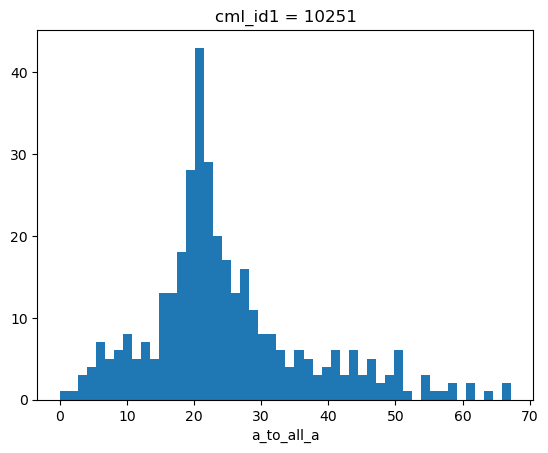

In [44]:
ds_dist.isel(cml_id1=250).a_to_all_a.plot.hist(bins=50);


In [45]:
r=15 # radius in km
ds_dist["within_r"] = (
        (ds_dist.a_to_all_a < r)
        & (ds_dist.a_to_all_b < r)
        & (ds_dist.b_to_all_a < r)
        & (ds_dist.b_to_all_b < r)
)

In [46]:
wet, F = nearby_wetdry.nearby_wetdry(
    pmin=pmin,
    ds_dist=ds_dist,
    radius=15,
    thresh_median_P=-1.4,
    thresh_median_PL=-0.7,
    min_links=3,
    interval=15,
    timeperiod=24,
)

100%|██████████| 364/364 [00:05<00:00, 72.60it/s]


In [47]:
ds_cml_zoom

<xarray.Dataset> Size: 277kB
Dimensions:           (sublink_id: 2, time: 1801)
Coordinates:
  * sublink_id        (sublink_id) <U9 72B 'sublink_1' 'sublink_2'
    cml_id            int64 8B 10124
  * time              (time) datetime64[ns] 14kB 2015-07-25T11:00:00 ... 2015...
    site_0_lat        float64 8B 57.74
    site_0_lon        float64 8B 12.16
    site_1_lat        float64 8B 57.74
    site_1_lon        float64 8B 12.13
    frequency         (sublink_id) float64 16B 3.727e+04 3.853e+04
    polarization      (sublink_id) <U1 8B 'v' 'v'
    length            float64 8B 2.113
Data variables:
    tsl               (time, sublink_id) float64 29kB 14.0 14.0 ... 14.0 14.0
    rsl               (time, sublink_id) float64 29kB -43.2 -44.5 ... -46.0
    R_example         (sublink_id, time) float64 29kB ...
    tl                (time, sublink_id) float64 29kB 57.2 58.5 ... 58.5 60.0
    rsd               (time, sublink_id) float64 29kB 0.4303 0.3904 ... 0.2354
    wet               (time, sublink_id) bool 4kB False False ... False False
    baseline          (sublink_id, time) float64 29kB 57.2 57.2 ... 60.0 60.0
    waa               (sublink_id, time) float64 29kB 0.0 0.0 0.0 ... 0.0 0.0
    A                 (time, sublink_id) float64 29kB 0.0 0.0 0.0 ... 0.0 0.0
    A_no_waa_correct  (time, sublink_id) float64 29kB 0.0 0.0 0.0 ... 0.0 0.0
Attributes: (12/14)
    title:                 OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

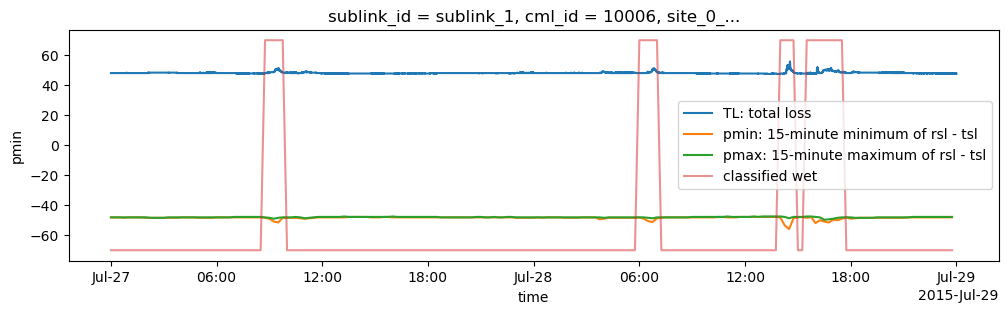

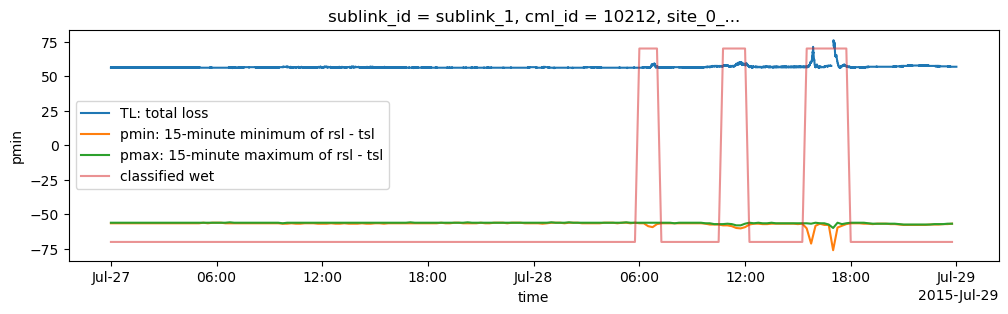

In [48]:
t_start, t_end = "2015-07-27", "2015-07-28 "
for cmlid in [5, 211]:
    (ds_cmls.isel(cml_id=cmlid).tsl - ds_cmls.isel(cml_id=cmlid).rsl).isel(sublink_id=0).sel(
        time=slice(t_start, t_end)
    ).plot(figsize=(12, 3), label="TL: total loss")
    pmin.isel(cml_id=cmlid,sublink_id=0).sel(time=slice(t_start, t_end)).plot(
        label="pmin: 15-minute minimum of rsl - tsl"
    )
    pmax.isel(cml_id=cmlid,sublink_id=0).sel(time=slice(t_start, t_end)).plot(
        label="pmax: 15-minute maximum of rsl - tsl"
    )
    (
        (wet.isel(sublink_id=0,cml_id=cmlid).sel(time=slice(t_start, t_end)) * 140)
        - 70
    ).plot(label="classified wet", alpha=0.5)

    plt.legend()

**Baseline estimation (pref)**  
The baseline is set to the rolling median of the average of pmin and pmax during the last n_average_dry time steps. Default is 24 hours (n_average_dry=96 because 15 minute temporal resolution) and a baseline will be calculated when at least one time step is available (min_periods=1) If pmax is not available e.g. because the min-max data is derived from instanteanous sampled CML data and has the same temporal resolution as the instanteanous CML data, substitute pmax with pmin so pmin and pmax are identical.

In [49]:
pref = nearby_rain.nearby_determine_reference_level(pmin, pmax, wet, n_average_dry=96, min_periods=1)


**Correction if min-max data**
Correcting pmin and pmax so that no rainfall estimation is carried out during dry time steps. All time steps of pmin which are not classified wet and pmin is smaller than pref are set to pref. Similarly, all time steps of pmax where either the corrected pmin (p_c_min) is not smaller than pref or pmax is not smaller than pref are set to pref. This ensures that only wet time steps are used for rainfall estimation an and that pmax is not above pref which would lead to an overestimation of rainfall.

In [50]:
p_c_min, p_c_max = nearby_rain.nearby_correct_received_signals(pmin, pmax, wet, pref)


**Calculate rain rates from attenuation data**
Also, correcting for wet antenna attenuation and setting the alpha value which defines how close to the minimum attenuation of each intervall the rain rate should be set.

In [51]:
R = nearby_rain.nearby_rainfall_retrival(
    pref,
    p_c_min,
    p_c_max,
    F,
    length=pmin.length,
    f_GHz=pmin.frequency / 1e3,
    pol=pmin.polarization,
    waa_max=2.3,
    alpha=0.33,
    F_value_threshold =-32.5,
)

In [66]:
# processing with RSD as done above, but now for all CMLs in one `xarray.Dataset`

# calculate wet periods
ds_cmls['roll_std_threshold'] = 1.1 * ds_cmls['tl'].rolling(time=60, center=True).std().quantile(0.85, dim='time')
ds_cmls['wet'] = ds_cmls.tl.rolling(time=60, center=True).std() > ds_cmls.roll_std_threshold

# calculate baseline
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet,
    n_average_last_dry=5,
)    

# calculate wet antenna effect
ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=6,
    zeta=0.7,  
    d=0.15, 
)

# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"] = ds_cmls.A.where(ds_cmls.A > 0, 0)
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,  
    f_GHz=ds_cmls.frequency / 1000,  
    pol=ds_cmls.polarization,
)
ds_cmls["R"].data[ds_cmls.R < 0.01] = 0

/Users/chwala-c/miniforge3/envs/prepep_os_processing/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


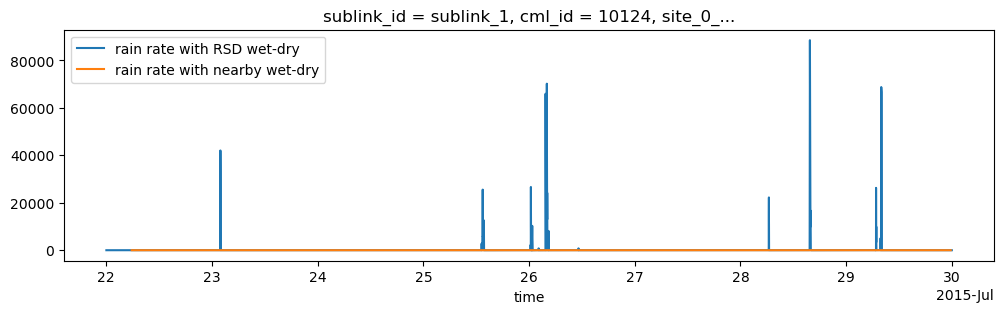

In [67]:
ds_cml = ds_cmls.isel(cml_id=123)

fig, ax = plt.subplots(figsize=(12,3))
ds_cml.isel(sublink_id=0).R.plot.line(x='time',label='rain rate with RSD wet-dry')
R.isel(sublink_id=0).sel(cml_id=ds_cml.cml_id.data).plot(label='rain rate with nearby wet-dry')
plt.legend()

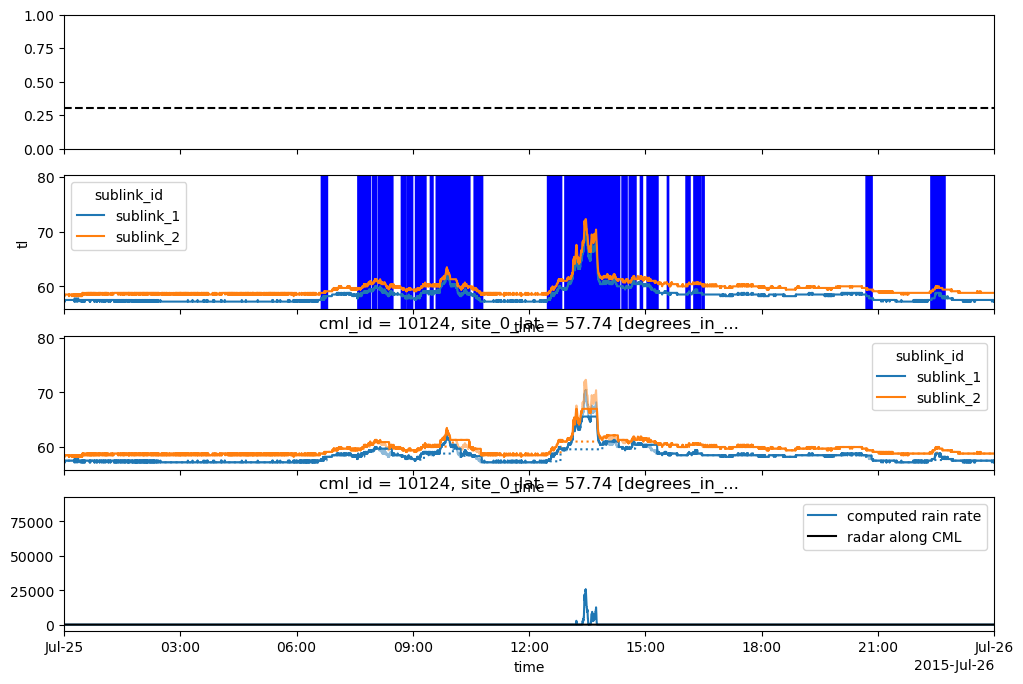

In [64]:
# Plotting function

fig, axs = plt.subplots(4, 1, figsize=(12,8), sharex=True)

# Plot RSL of TL and threshold
axs[0].axhline(threshold, color='k', linestyle='--', label='threshold')

# Plot TL and mark wet periods
ds_cml.tl.plot.line(x='time', ax=axs[1]);
highlight_wet_periods(ds_cml.wet, ax=axs[1])

# Plot TL, baseline and WAA
ds_cml.tl.plot.line(x='time', alpha=0.5, label='tl', ax=axs[2])

axs[2].set_prop_cycle(None)
ds_cml.baseline.plot.line(
    x='time', 
    linestyle=':', 
    label='baseline without WAA', 
    ax=axs[2]
)

axs[2].set_prop_cycle(None)
(ds_cml.baseline + ds_cml.waa).plot.line(
    x='time', 
    label='baseline with WAA', 
    ax=axs[2]
)

# Plot CML and radar rain rate
ds_cml.isel(sublink_id=0).R.plot.line(x='time',label='computed rain rate', ax=axs[3])
radar_along_cml.sel(cml_id=ds_cml.cml_id.data).plot.line(x='time', color='k', label='radar along CML', ax=axs[3])
plt.legend()

plt.xlim(pd.to_datetime('2015-07-25'), pd.to_datetime('2015-07-26'))

axs[0].set_title('');
axs[1].set_title('');